# Supplementary Information: Holmes *et al.* 2017

# 4. Varying base expression level

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

In our first unpooled model, we treated each probe as if there were an effect relating the measured *output* intensity to the *input* intensity for that probe, specific to the probe ID.  We treated that output value as some linear function of the input value, where the intercept $\alpha$ as though was a single pooled value for all probes. Here, we'll change that assumption so that we consider each probe to have an intercept that is specific to its *probe ID*.

This is in effect equivalent to fitting a different linear model to each *probe ID*.

We construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `sigma`: `real<lower=0>`, the error in the prediction

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a[probe[i]]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as $y \sim N(\hat{y}, \sigma^2)$.

In [2]:
# load clean, normalised, indexed data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

In [3]:
# define unpooled stan model
unpooled_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[probe[i]] + b[probe[i]] * x[i];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

In [4]:
# relate python variables to stan variables
unpooled_data_dict = {'N': len(data),
                      'J': nprobes,
                      'probe': data['probe_index'] + 1,
                      'x': data['input'],
                      'y': data['output']}

In [5]:
# run stan fit
unpooled_fit = pystan.stan(model_code=unpooled_model,
                           data=unpooled_data_dict,
                           iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea893bcfcd544b6213d01676f1caa5cf NOW.


## Inspecting the fit

Now there are (for the full dataset) now approximately 22000 parameters describing the slope and intercept for individual probe IDs. This is unwieldy. We can still get an estimate of the range of values those slopes and look at the potential for outliers - specific probe IDs that look as though they may deviate quite far from the mean of all estimates.

In [6]:
# Get fits to alpha and beta by probe ID
alpha_estimates = pd.Series(unpooled_fit['a'].mean(0), index=probe_ids)
alpha_se = pd.Series(unpooled_fit['a'].std(0), index=probe_ids)
beta_estimates = pd.Series(unpooled_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(unpooled_fit['b'].std(0), index=probe_ids)

In [7]:
# Inspect the estimates
alpha_estimates.head()

A_07_P038676    16.198009
A_07_P033759    12.953447
A_07_P033727    10.817718
A_07_P033715     0.995738
A_07_P040893   -83.099423
dtype: float64

In [8]:
# Inspect the estimates
beta_estimates.head()

A_07_P038676    -0.253825
A_07_P033759    -0.473301
A_07_P033727     0.062342
A_07_P033715    -0.635578
A_07_P040893    28.367125
dtype: float64

### Intercept $\alpha_{j[i]}$

Taking the intercept first, we can get an overview of the mean and standard error of $\alpha$:

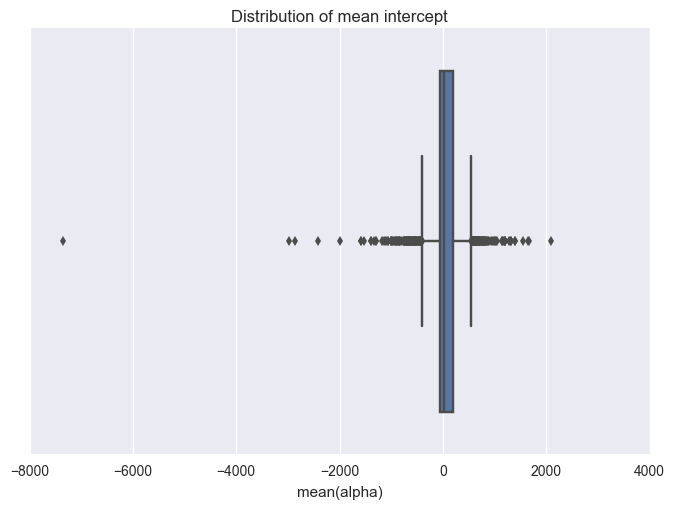

In [9]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

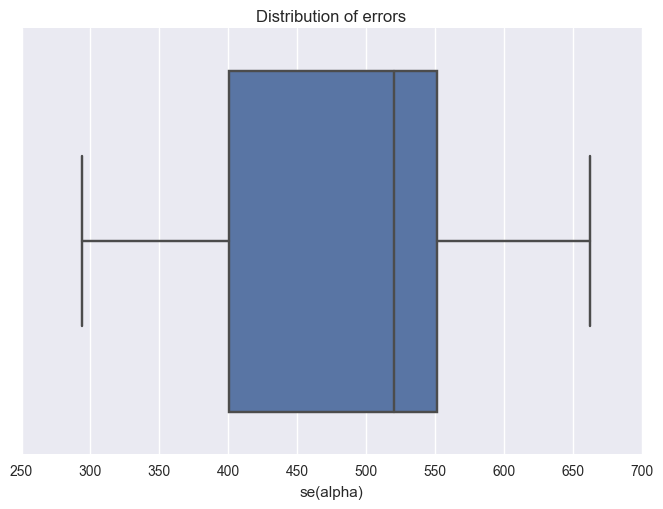

In [10]:
# Plot error distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of errors")
g.set_xlabel("se(alpha)");

The mean intercept values are all very small/close to zero, though generally positive, which is encouraging. The error in the estimate of intercept is, however, very large in all cases, and most of the time we seem not to be able to exclude the possibility that the true intercept is zero:

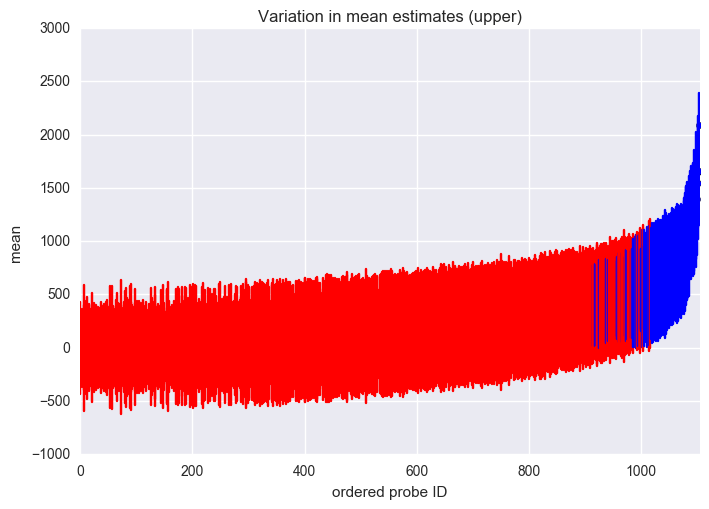

In [11]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, 0.9)

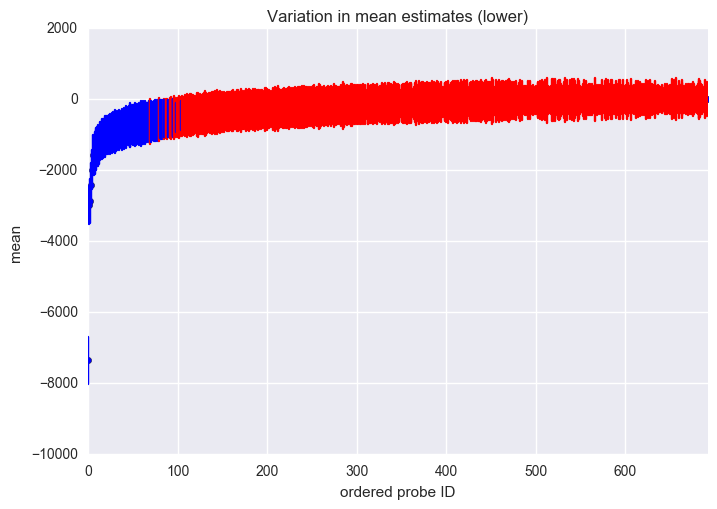

In [12]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, -1, upper=False)

### Slopes $\beta_{j[i]}$

The variation of slopes $\beta_{j[i]}$ by *probe ID* are the most interesting estimates, as they are indicative of the way *output* intensity measurements depend on *input* intensity measurements, and could help identify genes that are advantageous or disadvantageous in our experiment.

In our previous fit, we saw several strongly negative values of $\beta_{j[i]}$, and only a few positive coefficients.

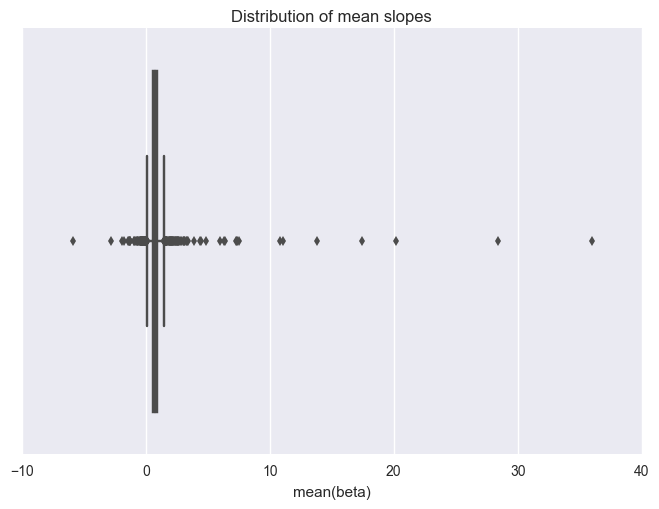

In [13]:
# Plot distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slopes")
g.set_xlabel("mean(beta)");

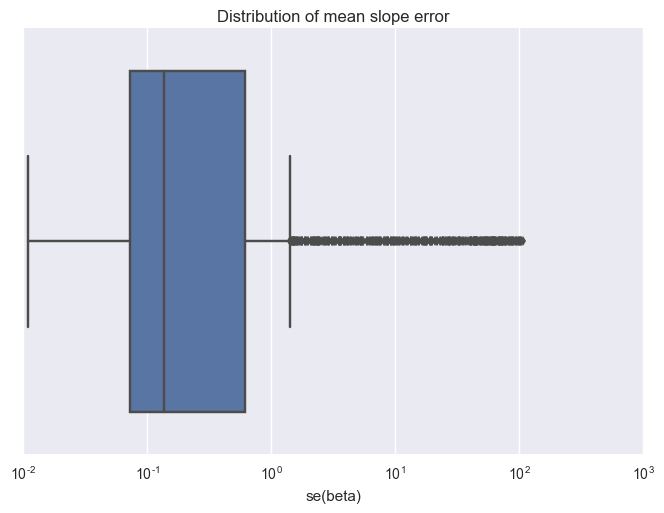

In [14]:
# Plot distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of mean slope error")
g.set_xscale("log")
g.set_xlabel("se(beta)");

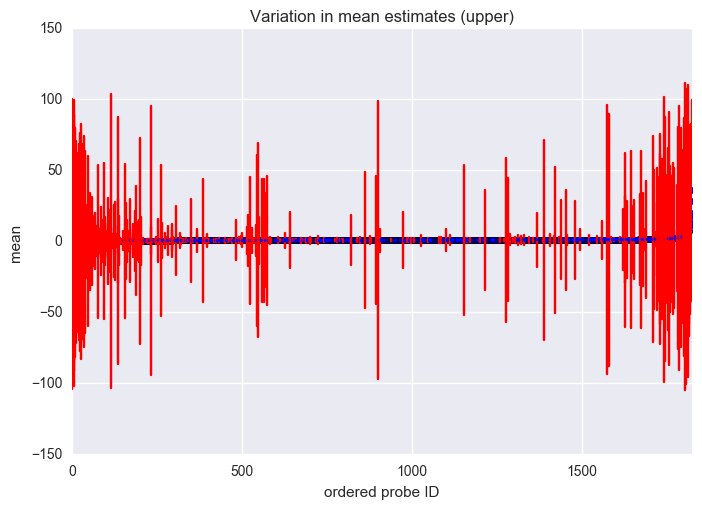

In [15]:
# plot all errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, -2)

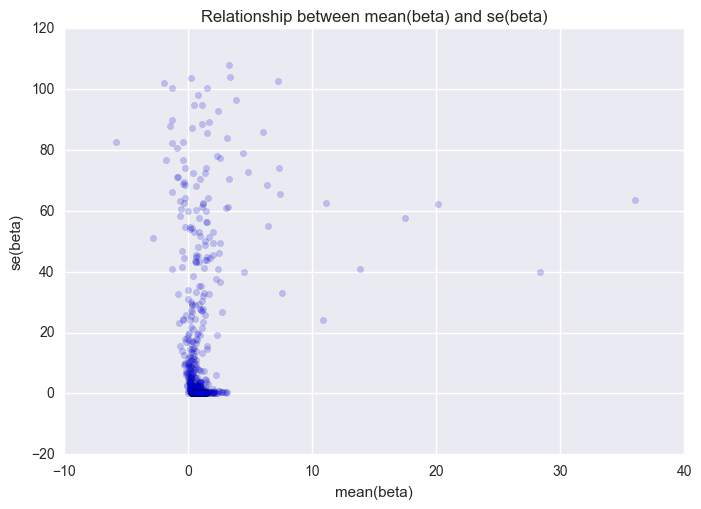

In [16]:
# How does estimate of error relate to error in the estimate
plt.scatter(beta_estimates, beta_se, alpha=0.2)
plt.title("Relationship between mean(beta) and se(beta)")
plt.xlabel("mean(beta)")
plt.ylabel("se(beta)");

As with estimates for the intercepts $\alpha_{j[i]}$, we see that errors are typically small, and on the order of the size of the estimate for the mean, or smaller. 

The most variable estimates tend to also be the extreme estimates of the mean, though the effect is not so clear as for our model with a constant pooled $\alpha$. All that has changed is that we now fit a *probe ID*-specific intercept - and the distribution of variable $\alpha_{j[i]}$ has now become less strongly related to the corresponding mean, suggesting that we have removed a specific biasing effect.

This is again potentially encouraging, if this variability is in fact due to an additional effect - that of the presence or absence of the treatment.

We can look at these extremes in more detail:

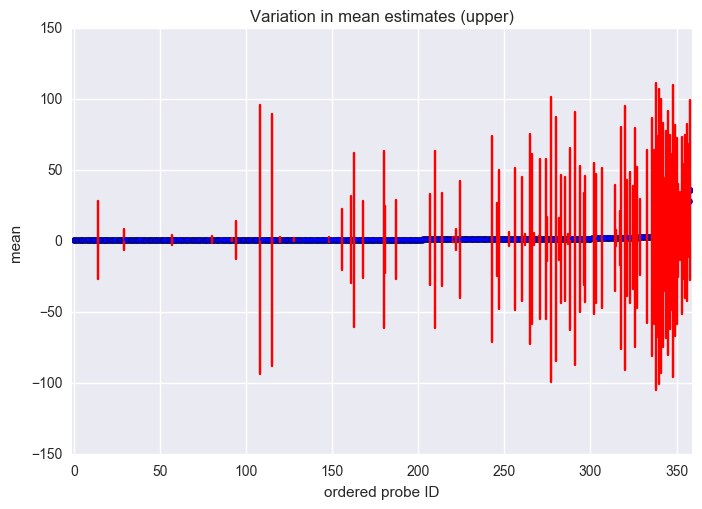

In [17]:
# plot positive errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, 1)

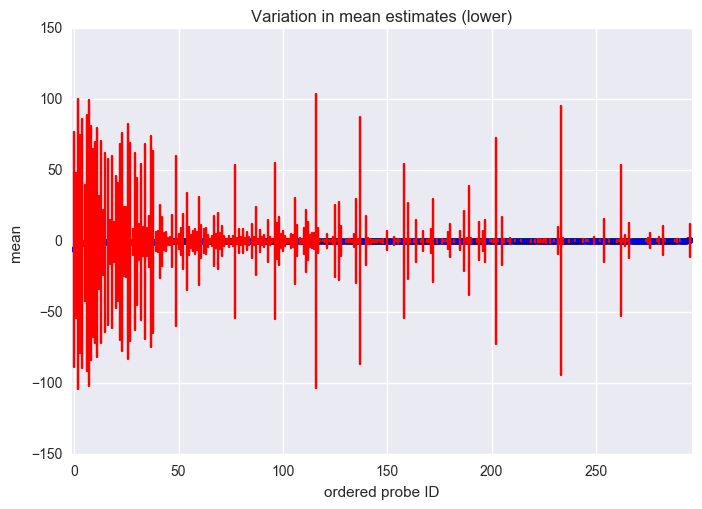

In [18]:
# plot negative errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, 0.5, upper=False)